In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [9]:
df = sns.load_dataset('penguins')
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


<Axes: xlabel='body_mass_g', ylabel='Density'>

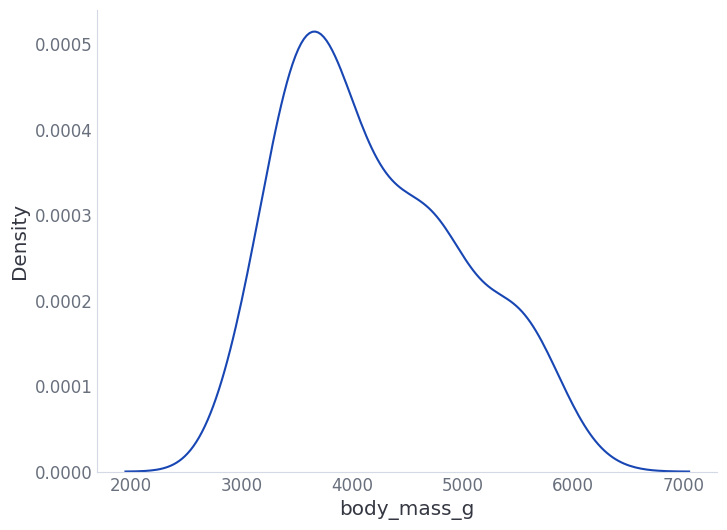

In [10]:
sns.kdeplot(df['body_mass_g'])

2023-12-08 15:08:51.927585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<Axes: xlabel='rate', ylabel='concentration'>

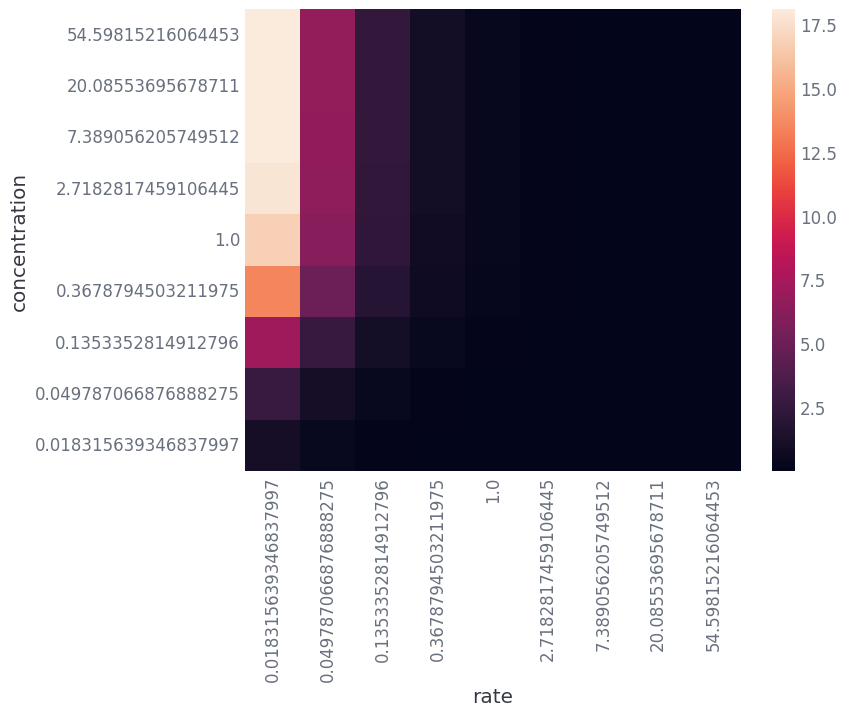

In [11]:
import jax
import jax.numpy as jnp
from types import SimpleNamespace
import numpyro.distributions as distr
import numpyro.distributions.constraints as constr

x = df['body_mass_g']

dist = distr.Gamma

arg_constrs = dist.arg_constraints

def pretty_constr(cons: constr.Constraint) -> str:
    if isinstance(cons, constr._Real):
        return 'ℝ'
    elif isinstance(cons, constr._Positive):
        return 'ℝ⁺'
    elif isinstance(cons, constr._OpenInterval):
        return f'({cons.lower_bound}, {cons.upper_bound})'
    elif isinstance(cons, constr._Interval):
        return f'[{cons.lower_bound}, {cons.upper_bound}]'
    elif isinstance(cons, constr._GreaterThan):
        return f'({cons.lower_bound}, ∞)'
    elif isinstance(cons, constr._LessThan):
        return f'(-∞, {cons.upper_bound})'
    else:
        return str(cons)

class Parameter:
    def __init__(self, name: str, domain: constr.Constraint, value=None):
        self.name = name
        self.domain = domain
        self.bijector = distr.transforms.biject_to(domain)
        if value is None:
            self.value = jnp.asarray(self.domain.feasible_like(jnp.zeros(1)), dtype='float32')
        else:
            self.value = value

    def __repr__(self):
        return f'{self.name} ∈ {pretty_constr(self.domain)} = {str(self.value)}'

    def get_unconstrained(self):
        return self.bijector.inv(self.value)

    def set_unconstrained(self, val):
        self.value = self.bijector(val)

    unconstrained = property(get_unconstrained, set_unconstrained)

class Parameters(SimpleNamespace):
    def __init__(self, params):
        super().__init__(**{p.name: p for p in params})
        self.param_names = [p.name for p in params]
        self.params = params
        self.param_dict = {p.name: p for p in params}

    def __getitem__(self, name):
        return self.param_dict[name]

    def __setitem__(self, name, v):
        self.param_dict[name] = v

    def __repr__(self):
        return 'Parameters{\n  ' + '\n  '.join(map(repr, self.params)) + '\n}'

    @property
    def values(self):
        return {p.name: p.value for p in self.params}

    def get_unconstrained(self):
        return {p.name: p.bijector.inv(p.value) for p in self.params}

    def set_unconstrained(self, vals):
        for k, v in vals.items():
            self.param_dict[k].unconstrained = v

    unconstrained = property(get_unconstrained, set_unconstrained)

theta = Parameters([Parameter(k, v) for k, v in arg_constrs.items()])
theta

tt = jnp.linspace(-4, 4, 9)
mesh = jnp.meshgrid(*[tt for _ in range(len(theta.param_dict))], copy=True)

defaults = theta
param = 'loc'

for k, m in zip(defaults.param_names, mesh):
    defaults[k].unconstrained = m.flatten()

def mean(theta):
    return dist(**theta).mean

def std(theta):
    return jnp.sqrt(dist(**theta).variance)

def median(theta):
    return dist(**theta).icdf(0.5)

def skew(theta):
    return mean(theta) - median(theta)

mu = mean(defaults.values)
# d_mu = jax.vmap(jax.grad(mean))

sdf = {}
for k in defaults.param_names:
    sdf[k] = defaults[k].value
    sdf[k + '_raw'] = defaults[k].unconstrained

sdf['μ'] = mean(defaults.values)
sdf['σ'] = std(defaults.values)
sdf['skew'] = skew(defaults.values)
sdf = pd.DataFrame(sdf)

sns.heatmap(sdf.pivot_table(index=defaults.param_names[1], columns=defaults.param_names[0], values='skew').T.iloc[::-1, :], annot=False, robust=True)

# sns.relplot(sdf, x='loc', y='X', hue='scale', kind='line')

In [ ]:
stats = ['μ', 'σ', 'skew']
rows = []
query = f'{sdf.columns[0]} == {sdf.columns[0]}'
# query = 'scale_raw == 0'
for param in theta.param_names:
    total = sdf[stats].std(ddof=0)
    rows.append(1 - (sdf.query(query).groupby(param).std(ddof=0)[stats].mean() / total))

rows = pd.DataFrame(rows, index=pd.Series(theta.param_names, name='param'))
rows

,μ,σ,skew
param,,,
concentration,0.559778,0.385769,0.144748
rate,0.559778,0.613103,0.745928
